# Warning
If you are looking for the non-technical part of this project, I would advise you to click on the following link: [Vehicle insurance cross-sell](https://github.com/cenciati/portfolio/tree/main/vehicle-insurance-cross-sell), and there you will find everything you need to know about this project.

# 0. Imports

## 0.1. Libraries

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import psycopg2 as pg

# data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# data balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# preprocessing
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from boruta import BorutaPy

# machine learning
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# other
import os
from sys import path
path.append('../src')
import joblib
from IPython.display import Image
from flask import Flask, request, Response
import json
import requests

# my tool box
from mytoolbox import MyToolBox
mtb = MyToolBox()
mtb.jupyter_settings(filterwarnings=True)

Jupyter settings set.


## 0.2. Helper functions

In [2]:
def train_model(estimator, x_train, y_train, x_val, y_val, figsize=(20, 6)):
    '''Train and evaluate machine learning algorithm without cross-validation.
    
    Parameters
    ----------
    estimator : object
        Machine learning algorithm to evaluate. 
    x_train : pandas dataframe
        The data to train.
    y_train : pandas series
        The target variable from the training data.
    x_val : pandas dataframe
        The data to validate.
    y_val : pandas series
        The target variable from the validation data.
    figsize : tuple, default=(20, 6)
        Width and height from the figure respectively.
    
    Returns
    -------
    numpy array.
    '''
    # instantiate and fit the model
    clf = estimator.fit(x_train, y_train)

    # predict
    p_hat = clf.predict_proba(x_val)

    # plot settings
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    (ax1, ax2) = ax

    # plot cumulative gain
    plot_cumulative_gain(y_val, p_hat, ax=ax1);

    # plot lift curve
    plot_lift_curve(y_val, p_hat, ax=ax2);
    
    return p_hat


def precision_at_k(data, p_hat, k=1_000):
    '''Calculate precision at k.
    (# of recommended items at k that are relevant) / (# of recommended items at k)
    
    Parameters
    ----------
    data : pandas dataframe
        The entire data to evaluate.
    p_hat : numpy array
        Predicted probabilities 
    k : int, default=1.000
        Number of most likely outcomes considered to find the correct label.
    
    Returns
    -------
    pandas dataframe.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create precision at k column
    data['precision_at_k'] = np.round(data['response'].cumsum() / data['ranking'], 4)
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, p_hat, k=1_000):
    '''Calculate recall at k.
    (# of recommended items at k that are relevant) / (total # of relevant items)

    Parameters
    ----------
    data : pandas dataframe
        The entire data to evaluate.
    p_hat : numpy array
        Predicted probabilities 
    k : int, default=1.000
        Number of most likely outcomes considered to find the correct label.
    
    Returns
    -------
    pandas dataframe.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create recall at k column
    data['recall_at_k'] = np.round(data['response'].cumsum() / data['response'].sum(), 4)
    
    return data.loc[k, 'recall_at_k']


def cross_validation(estimator, x, y, n_splits=5, shuffle=False, verbose=False):
    '''Evaluate precision and recall at k of a machine learning model by cross-validation.
    
    Parameters
    ----------
    estimator : object
        Machine learning algorithm to evaluate. 
    x : pandas dataframe
        The data to fit.
    y : pandas dataframe
        The target variable from the x data.
    n_splits : int, default=5
        Number of iterations.
    shuffle : boolean, default=False
        Whether the data should be shuffled.
    verbose : boolean, default=False
        The verbosity level.
    
    Returns
    -------
    None.
    '''
    # counter
    i = 1

    # lists to store the results
    precision_at_k_list, recall_at_k_list = [], []
    
    skf = ms.StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    for train_ix, val_ix in skf.split(x, y):
        if verbose:
            print(f'Fold number: {i}/{n_splits}')
            i += 1
        
        # split data
        x_train = x.iloc[train_ix]
        y_train = y.iloc[train_ix]
        
        x_val = x.iloc[val_ix]
        y_val = y.iloc[val_ix]
        
        # instantiate and fit the classifier
        clf = estimator.fit(x_train, y_train)

        # predict probability
        p_hat = clf.predict_proba(x_val)
        
        # prepare data
        df = x_val.copy()
        df['response'] = y_val.astype('int64').copy()
        
        # define K
        K = np.floor((1/2) * (y_val.shape[0]))
        
        # calculate precision at k
        precision_at_k_list.append(precision_at_k(df, p_hat, K))
        
        # calculate recall at k
        recall_at_k_list.append(recall_at_k(df, p_hat, K))
    
    # print the results
    print(f'Precision@K: {np.round(np.mean(precision_at_k_list), 4)} +/- {np.round(np.std(precision_at_k_list), 4)}')
    print(f'Recall@K: {np.round(np.mean(recall_at_k_list), 4)} +/- {np.round(np.std(recall_at_k_list), 4)}')
    
    return None

## 0.3. Data acquisition
**Data source**: AWS Redshift

In [3]:
# define credentials
credentials_db = {
    'user': os.getenv('HICS_USER'),
    'password': os.getenv('HICS_PASSWORD'),
    'host': os.getenv('HICS_HOST'),
    'port': 5432,
    'database': os.getenv('HISC_DATABASE')
}

In [4]:
try:
    # create connection
    conn = pg.connect(user=credentials_db['user'],
                      password=credentials_db['password'],
                      host=credentials_db['host'],
                      port=credentials_db['port'],
                      database=credentials_db['database'])
    
    # create join tables query
    query = '''
        SELECT *
        FROM pa004.users u
            LEFT JOIN pa004.insurance i ON (u.id = i.id)
            LEFT JOIN pa004.vehicle v ON (u.id = v.id)
    '''
    
    # read tables
    df_raw = pd.read_sql(query, conn)

    # close cursor and connection
    conn.close()

except Exception as error:
    print('Error trying to connect to the database.', error)

finally:
    if conn:
        conn.close()
        print('Connection was closed.')

Connection was closed.


In [5]:
# delete repeated id columns
columns_to_stay = list(np.append(0, np.where(df_raw.columns != 'id')[0]))
df_raw = df_raw.iloc[:, columns_to_stay]

In [6]:
# split data into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(df_raw.drop('response', axis=1), df_raw['response'], test_size=0.1)

In [7]:
# concatenate train data into a unique dataframe
df_raw = pd.concat([X_train, y_train], axis=1)
df_raw.sample(10)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
179935,295076,Male,39,28.0000,122.0000,0,30341.0000,20,1,1-2 Year,No,0
112915,139293,Male,30,36.0000,152.0000,0,40320.0000,130,1,< 1 Year,Yes,0
322228,288571,Male,41,48.0000,15.0000,0,2630.0000,65,1,1-2 Year,Yes,0
116365,166842,Male,22,28.0000,124.0000,1,35163.0000,225,1,1-2 Year,No,0
157808,117502,Male,46,3.0000,124.0000,1,37350.0000,156,1,1-2 Year,No,0
235665,357637,Male,22,35.0000,152.0000,1,31109.0000,197,1,< 1 Year,No,0
23781,189923,Male,23,33.0000,152.0000,1,42402.0000,82,1,< 1 Year,No,0
65431,141534,Male,28,41.0000,152.0000,1,48704.0000,26,1,< 1 Year,No,0
250174,93727,Male,54,43.0000,156.0000,0,2630.0000,139,1,1-2 Year,Yes,0
7235,58448,Female,29,30.0000,152.0000,1,2630.0000,236,1,< 1 Year,No,0


# 1. Data cleansing and description

## Index

Column | Meaning
------ | -------
id | Unique identifier
gender | Gender
age | Age
region_code | Region code
policy_sales_channel | Code identifying the customer's contact (e.g., mail, phone)
previously_insured | 0 = He/She didn't have vehicle insurance before; 1 = He/She already had vehicle insurance before
annual_premium | Amount paid per year
vintage | Number of days customers are associated with the company
response | 0 = Interested; 1 = Not interested
driving_license | 0 = He/She does not have drive license; 1 = He/She has drive license
vehicle_age | Vehicle age categorized
vehicle_damage | 0 = Vehicle was damaged before; 1 = Vehicle was not damaged before

## 1.1. Data dimensions

In [8]:
print('Rows: {:,}\nColumns: {}'.format(df_raw.shape[0], df_raw.shape[1]))

Rows: 342,998
Columns: 12


## 1.2. Duplicate data

In [9]:
df_raw.duplicated().sum()

0

## 1.3. Data types

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342998 entries, 273483 to 121958
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   gender                342998 non-null  object 
 2   age                   342998 non-null  int64  
 3   region_code           342998 non-null  float64
 4   policy_sales_channel  342998 non-null  float64
 5   previously_insured    342998 non-null  int64  
 6   annual_premium        342998 non-null  float64
 7   vintage               342998 non-null  int64  
 8   driving_license       342998 non-null  int64  
 9   vehicle_age           342998 non-null  object 
 10  vehicle_damage        342998 non-null  object 
 11  response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.0+ MB


In [11]:
# convert to integer
for col in ['region_code', 'policy_sales_channel']:
    df_raw[col] = df_raw.loc[:, col].astype('int64')

# convert to category
for col in ['gender', 'vehicle_age', 'vehicle_damage']:
    df_raw[col] = df_raw.loc[:, col].astype('category')

## 1.4. Missing data

In [12]:
# check null values percentage by column
(df_raw.isna().sum() /len(df_raw)).sort_values(ascending=False)

id                     0.0000
gender                 0.0000
age                    0.0000
region_code            0.0000
policy_sales_channel   0.0000
previously_insured     0.0000
annual_premium         0.0000
vintage                0.0000
driving_license        0.0000
vehicle_age            0.0000
vehicle_damage         0.0000
response               0.0000
dtype: float64

## 1.5. Outliers

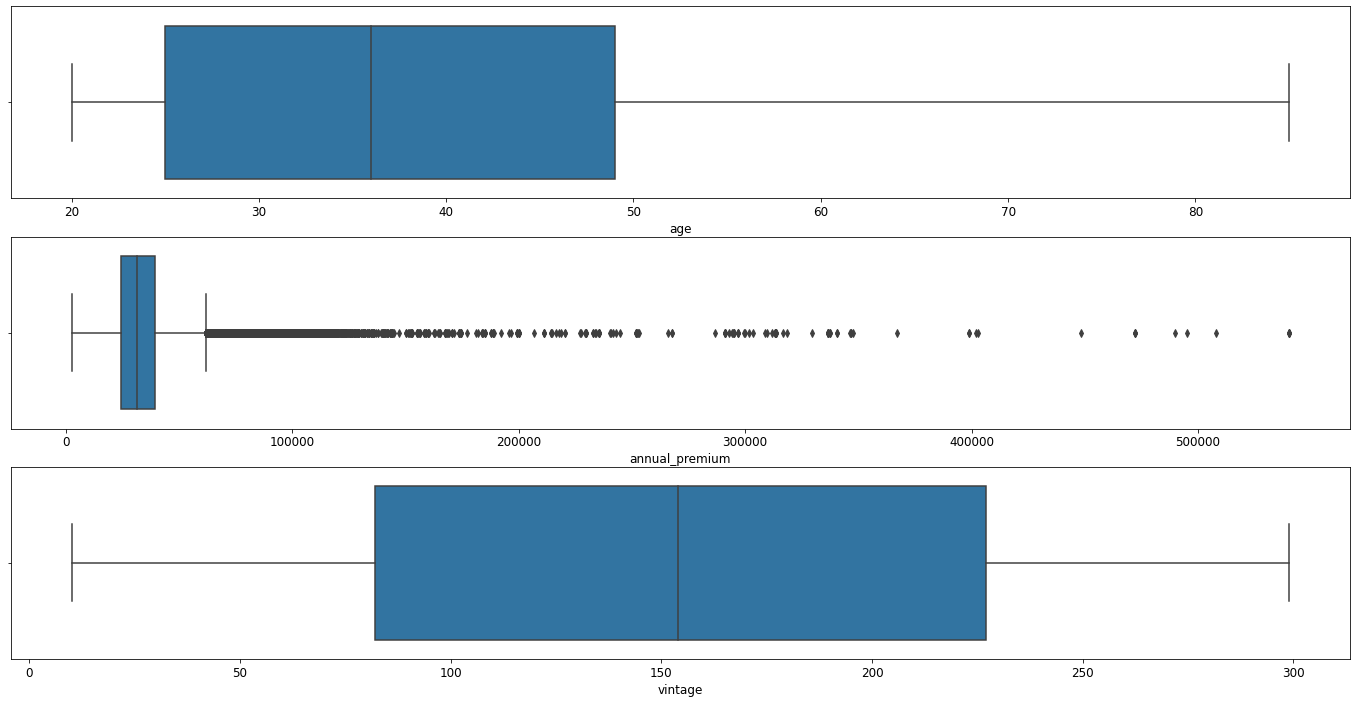

In [13]:
# define figure
_, ax = plt.subplots(nrows=3, ncols=1)
(ax1, ax2, ax3) = ax

# plot
sns.boxplot(x='age', data=df_raw, ax=ax1);
sns.boxplot(x='annual_premium', data=df_raw, ax=ax2);
sns.boxplot(x='vintage', data=df_raw, ax=ax3);

In [14]:
# rows before deleting outliers
print('Before: {:,}'.format(len(df_raw)))

# calculate quantiles
q75, q25 = np.percentile(df_raw['annual_premium'], 75), np.percentile(df_raw['annual_premium'], 25)

# calculate interquantile range
iqr = q75 - q25

# calculate outliers cut off
cut_off = 1.5 * iqr
lower, upper = q25 - cut_off, q75 + cut_off

# remove outliers
df_raw = df_raw.loc[[False if x <= lower or x >= upper else True for x in df_raw['annual_premium']]]

# rows after deleting outliers
print('After: {:,}'.format(len(df_raw)))

Before: 342,998
After: 333,731


## 1.6. Imbalance

* **High data imbalance**:
    * **Class 0**: 87.8%
    * **Class 1**: 12.2%

In [15]:
df_raw['response'].value_counts(normalize=True)

0   0.8783
1   0.1217
Name: response, dtype: float64

## 1.7. Descriptive statistics

In [16]:
# only numerical features
num_features = df_raw[['age', 'annual_premium', 'vintage']]

# only categorical features
cat_features = df_raw.select_dtypes(include=['object', 'category'])

### 1.7.1. Numerical features

In [17]:
# calculate central tendency and disperion for each numerical column
num_features_stats = pd.DataFrame({'Mean': num_features.apply(np.mean),
                                     'Median': num_features.apply(np.median),
                                     'Std. deviation': num_features.apply(np.std),
                                     'Min': num_features.apply(np.min),
                                     'Max': num_features.apply(np.max),
                                     'Range': num_features.apply(lambda x: np.max(x) - np.min(x)),
                                     'Skew': num_features.apply(lambda x: x.skew()),
                                     'Kurtosis': num_features.apply(lambda x: x.kurtosis())})

# check it out
num_features_stats.style.highlight_max(subset=['Range', 'Skew', 'Kurtosis'], color='yellow')

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
age,38.674028,36.000000,15.440875,20.000000,85.000000,65.000000,0.683283,-0.543801
annual_premium,29273.225310,31323.000000,14755.739623,2630.000000,61949.000000,59319.000000,-0.517929,-0.335226
vintage,154.333098,154.000000,83.661321,10.000000,299.000000,289.000000,0.003247,-1.200404


### 1.7.2. Categorical features

In [18]:
cat_features.describe().T

,count,unique,top,freq
gender,333731,2,Male,180367
vehicle_age,333731,3,1-2 Year,174871
vehicle_damage,333731,2,Yes,167988


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [19]:
# age
df_raw['older_than_36'] = df_raw['age'].apply(lambda x: 1 if x > 36 else 0)

# vintage
df_raw['vintage_weeks'] = df_raw['vintage'].apply(lambda x: x/7)
df_raw['vintage_months'] = df_raw['vintage'].apply(lambda x: x/30)

# annual_premium
df_raw['annual_premium_per_age'] = df_raw['annual_premium'] / df_raw['age']
df_raw['annual_premium_per_vintage'] = df_raw['annual_premium'] / df_raw['vintage']
df_raw['annual_premium_per_vintage_weeks'] = df_raw['annual_premium'] / df_raw['vintage_weeks']
df_raw['annual_premium_per_vintage_months'] = df_raw['annual_premium'] / df_raw['vintage_months']

# customer characteristic
df_raw['customer_characteristic'] = df_raw['gender'].map({'Male': 0, 'Female': 1}).astype('int64')\
                                    + df_raw['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('int64')\
                                    + df_raw['vehicle_damage'].map({'No': 0, 'Yes': 1}).astype('int64')\
                                    + df_raw['previously_insured'].astype('int64')\
                                    + df_raw['age'].apply(lambda x: 2 if x >= 20 and x < 40
                                                                      else 1 if x >=40 and x < 60
                                                                      else 0)

## 2.2. Filtering

In [20]:
# df_raw[(df_raw['driving_license'] == 0) & (df_raw['vehicle_age'] != '< 1 Year')]

## Checkpoint

In [21]:
# save data to parquet format
df_raw.to_parquet('../data/interim/df_cleaned')

# load cleaned data
df = pd.read_parquet('../data/interim/df_cleaned')

# delete old data set
del df_raw

# 3. Exploratory data analysis

## Automatic EDA

In [22]:
# generate complete eda using pandas profiling
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Exploratory data analysis (Pandas profiling)', minimal=True)
profile.to_file('../data/interim/pp-exploratory-data-analysis.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 251.79it/s]


## 3.1. Univariate analysis

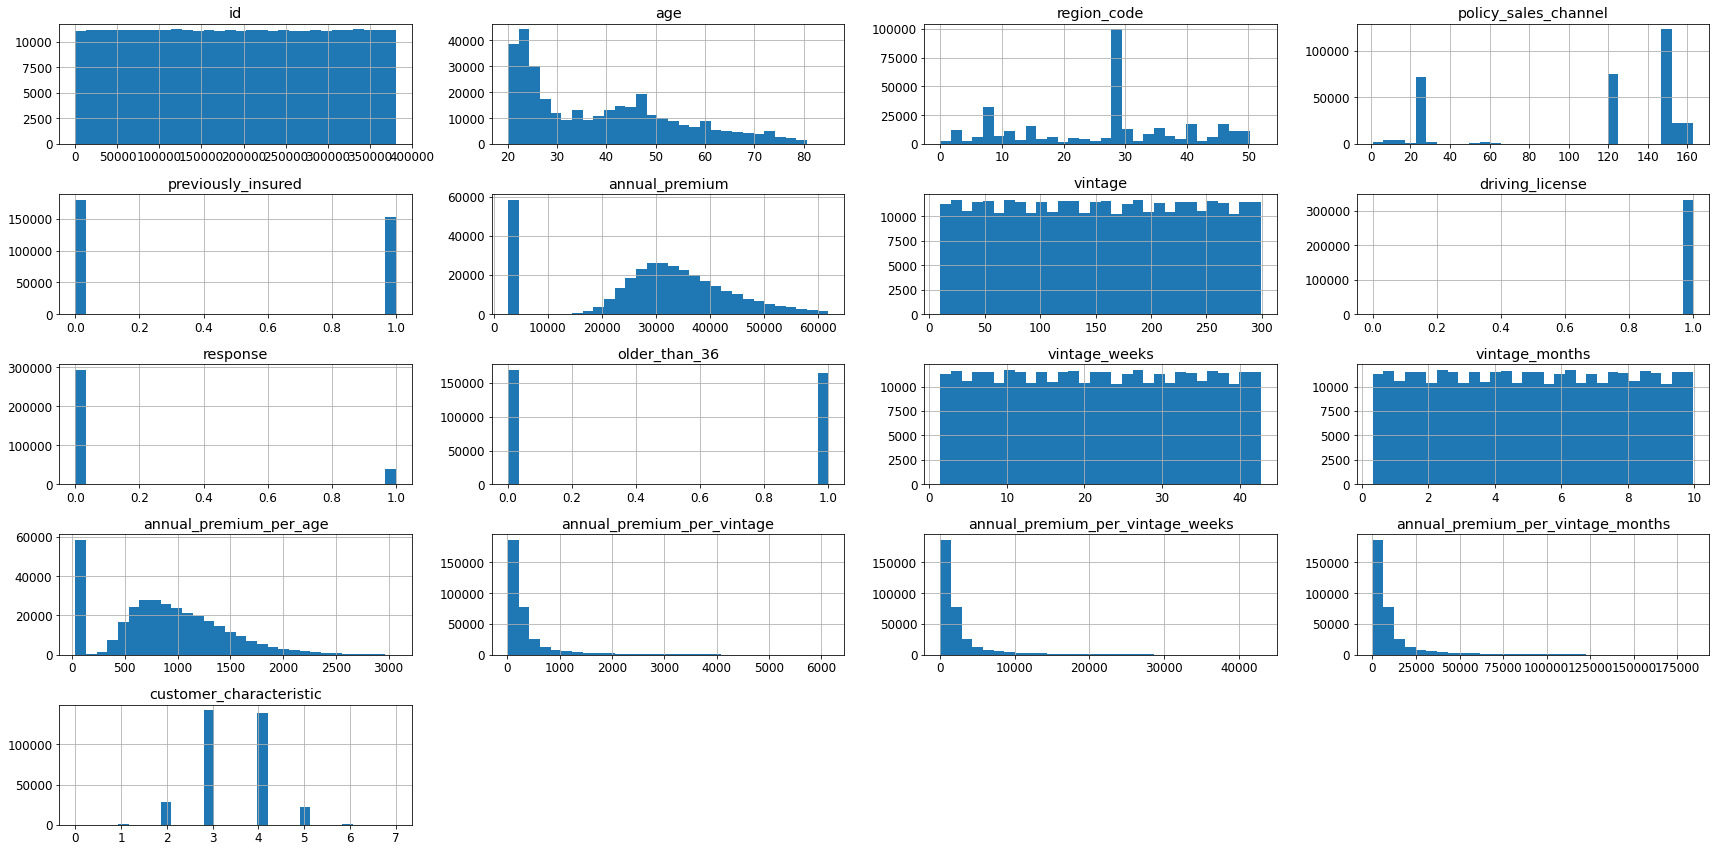

In [23]:
# plot
df.hist(bins=30);
plt.tight_layout()

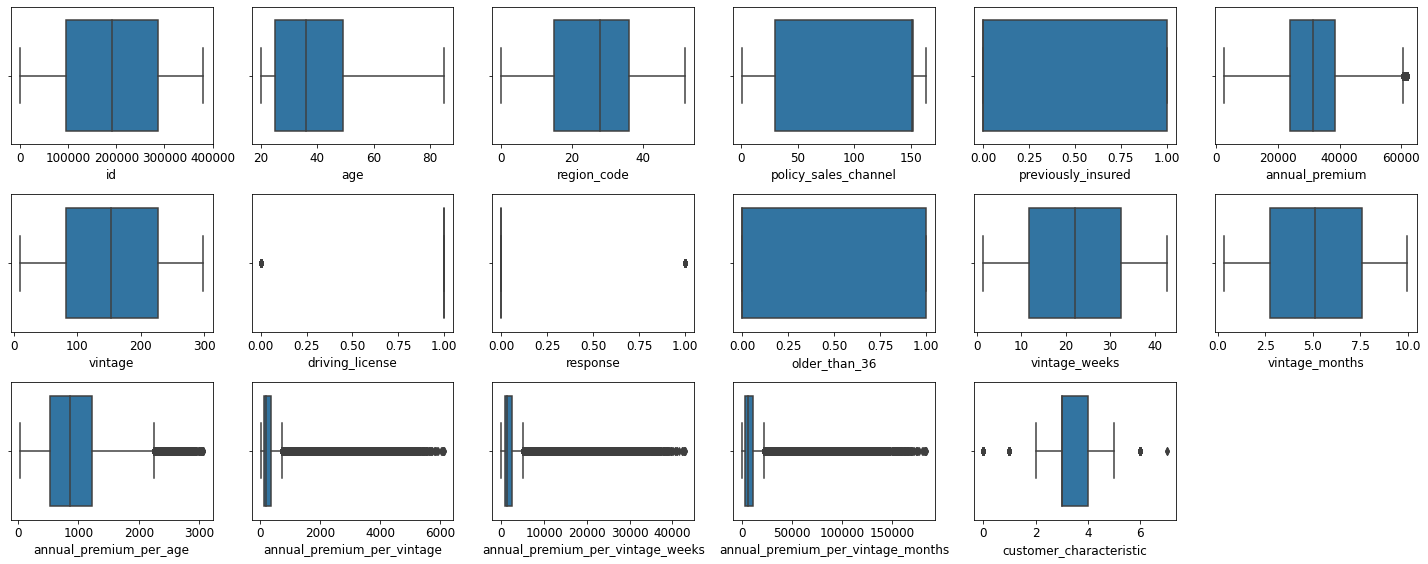

In [24]:
# plot settings
univariate_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 8))

# plot
for i in range(0, len(univariate_columns)):
    plt.subplot(3,6,i+1)
    sns.boxplot(x=df[univariate_columns[i]])
    plt.tight_layout()

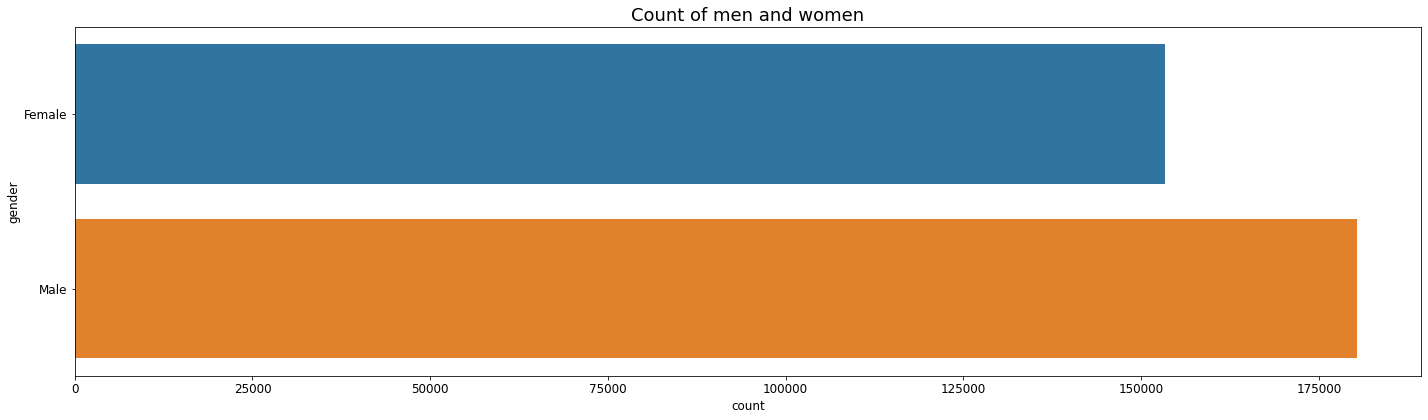

In [25]:
# plot
plt.figure(figsize=(20, 6))
sns.countplot(y=df['gender']);
plt.title('Count of men and women', fontsize=18);
plt.tight_layout()

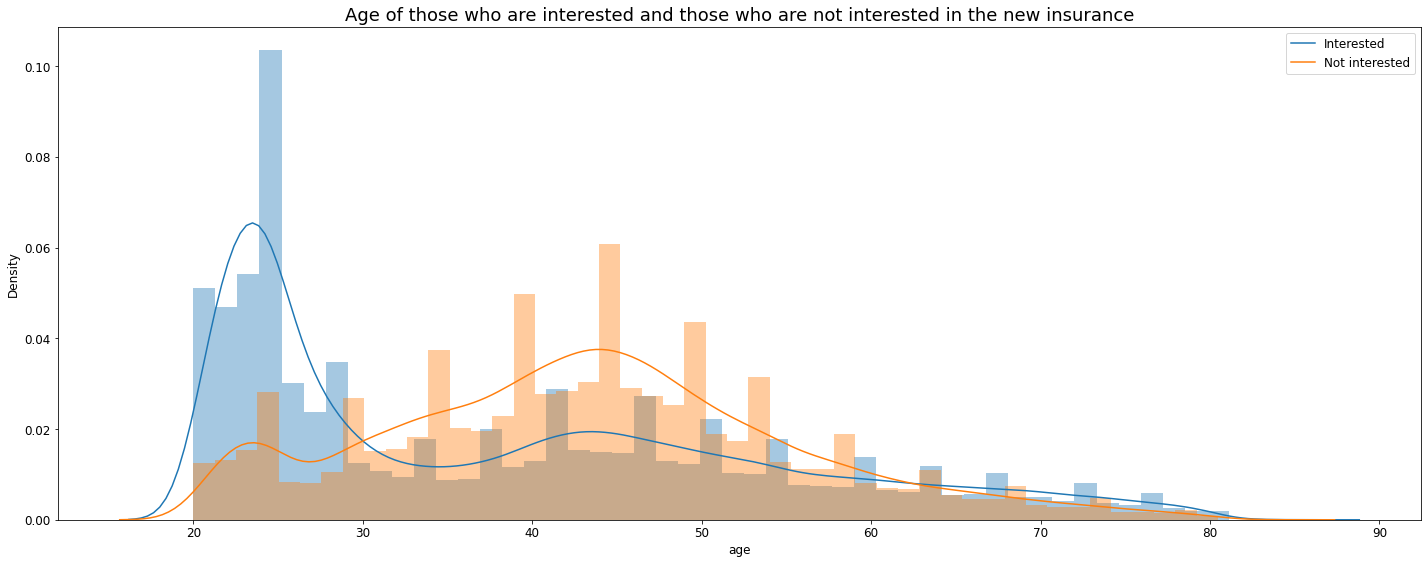

In [26]:
# plot settings
plt.figure(figsize=(20,8))

# plot
sns.distplot(df.loc[df['response'] == 0, 'age']);
sns.distplot(df.loc[df['response'] == 1, 'age']);
plt.title('Age of those who are interested and those who are not interested in the new insurance', fontsize=18);
plt.legend(['Interested', 'Not interested']);
plt.tight_layout()

## 3.2. Bivariate analysis

## Problem mind map

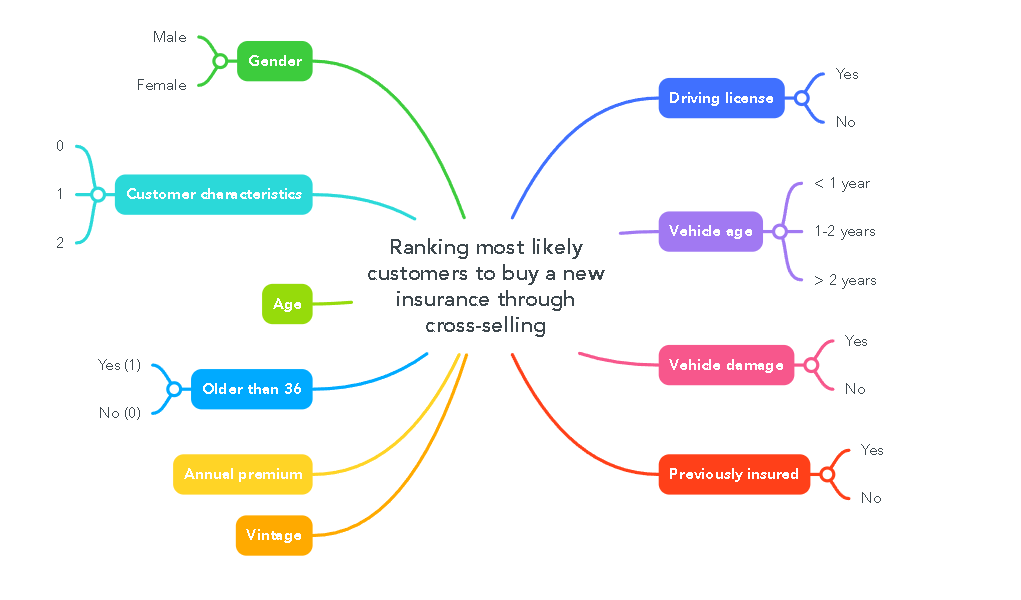

In [27]:
Image('../imgs/mind-map.png')

## Hypotheses list

ID     | Hypothesis | Relevance | Conclusions
-------|------------|-----------|-------------
H01.   |Customers without driving licenses tend to want less vehicle insurance|<font color='blue'>Low</font>|<font color='green'>True</font>
H02.   |Women tend to want more vehicle insurance| <font color='yellow'>Medium</font>| <font color='red'>False</font>
H03.   |Customers aged between 36-45 tend to want more vehicle insurance|<font color='yellow'>Medium</font>|<font color='red'>False</font>
H04.   |Customers with a history of damage to their vehicle tend to want more vehicle insurance|<font color='red'>High</font>|<font color='green'>True</font>
H05.   |Customers with new vehicles (< 1 year) tend to want more vehicle insurance|<font color='red'>High</font> |<font color='red'>False</font>

### 3.2.1. Hypothesis 01 - Customers without driving licenses tend to want less vehicle insurance
<font color='green'>True</font>

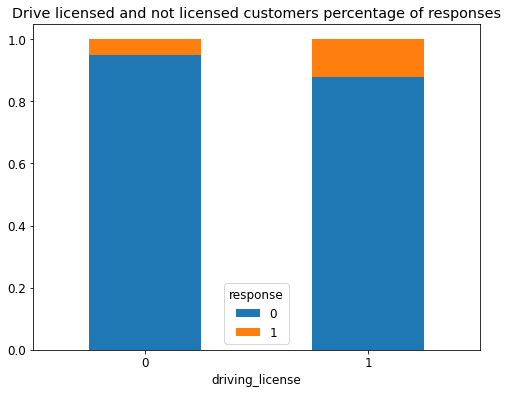

In [28]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['driving_license'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Drive licensed and not licensed customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.2. Hypothesis 02 - Women tend to want more vehicle insurance
<font color='red'>False</font>

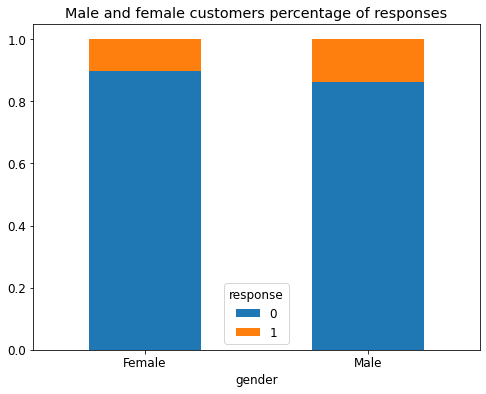

In [29]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['gender'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Male and female customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.3. Hypothesis 03 - Customers aged between 36-45 tend to want more vehicle insurance
<font color='red'>False</font>

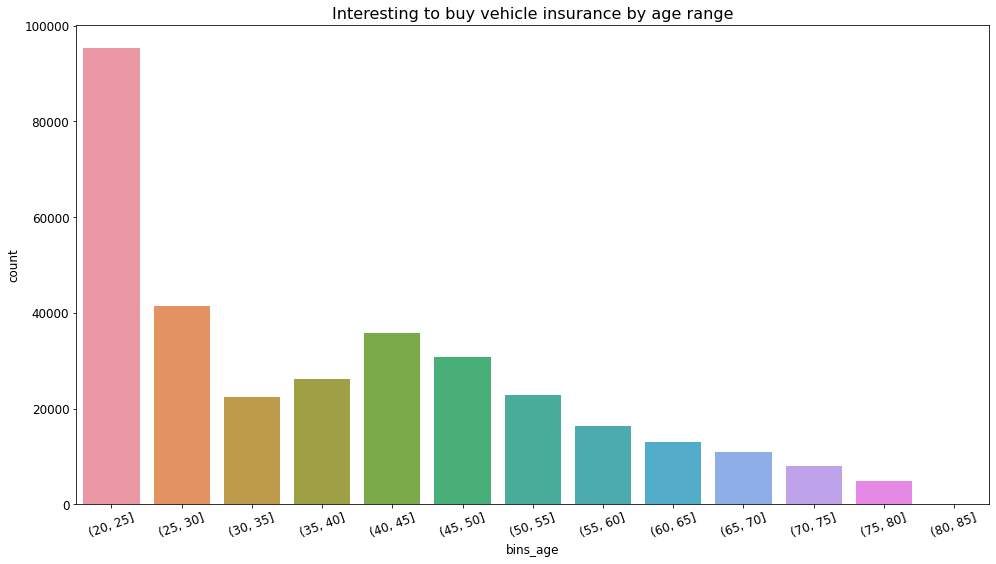

In [30]:
# define data
aux = df.copy()

# bins
n_bins = list(np.arange(df['age'].min(), df['age'].max()+1, 5))
aux['bins_age'] = pd.cut(aux['age'], bins=n_bins)

# plot
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
sns.countplot(aux['bins_age'], ax=ax);
plt.title('Interesting to buy vehicle insurance by age range', fontsize=16);
plt.xticks(rotation=20);
plt.tight_layout()

### 3.2.4. Hypothesis 04 - Customers with a history of damage to their vehicle tend to want more vehicle insurance
<font color='green'>True</font>

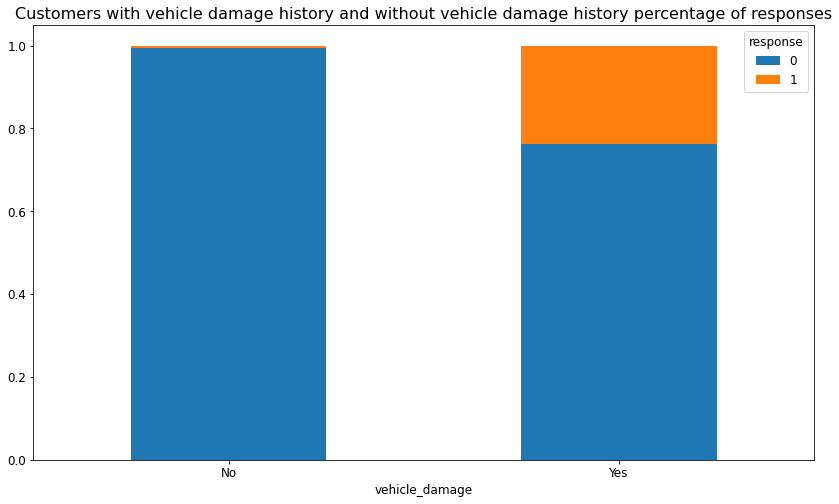

In [31]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
pd.crosstab(df['vehicle_damage'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with vehicle damage history and without vehicle damage history percentage of responses', fontsize=16);
plt.xticks(rotation=0);

### 3.2.5. Hypothesis 05 - Customers with new vehicles (< 1 year) tend to want more vehicle insurance
<font color='red'>False</font>

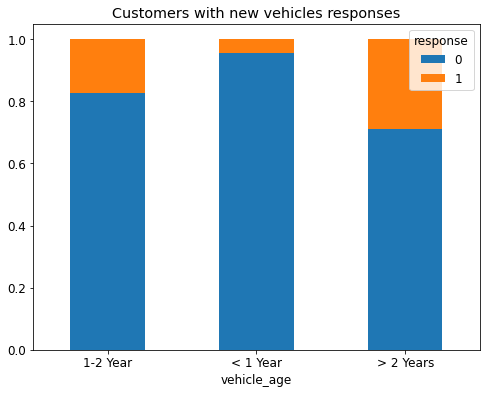

In [32]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['vehicle_age'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with new vehicles responses');
plt.xticks(rotation=0);

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

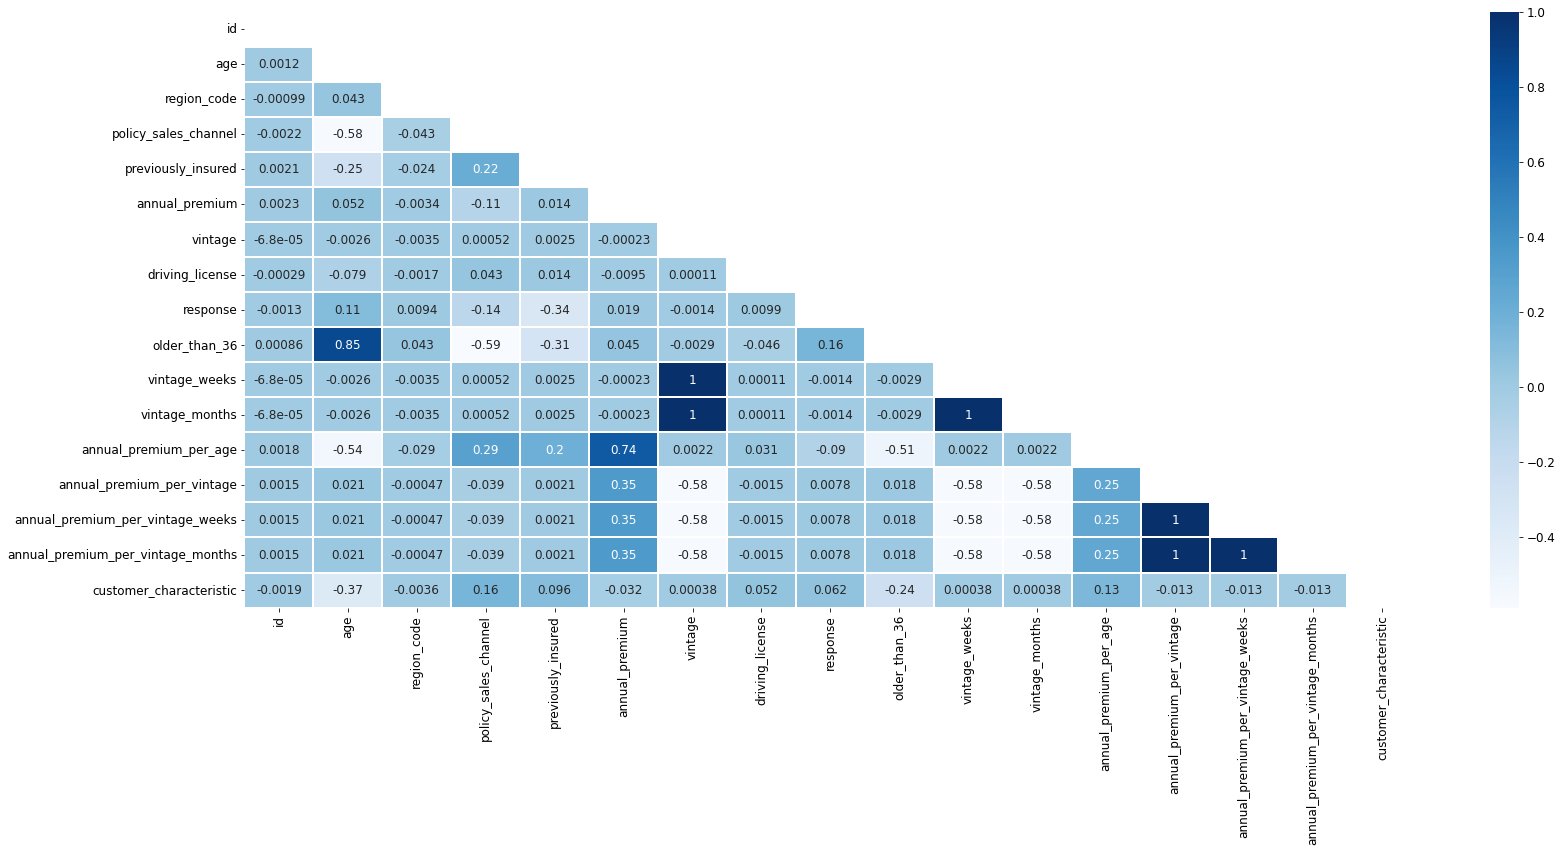

In [33]:
# compute the correlation matrix
num_corr = df.select_dtypes(include=['int64', 'float64']).corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(num_corr, dtype=bool))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(num_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

### 3.3.2. Categorical variables

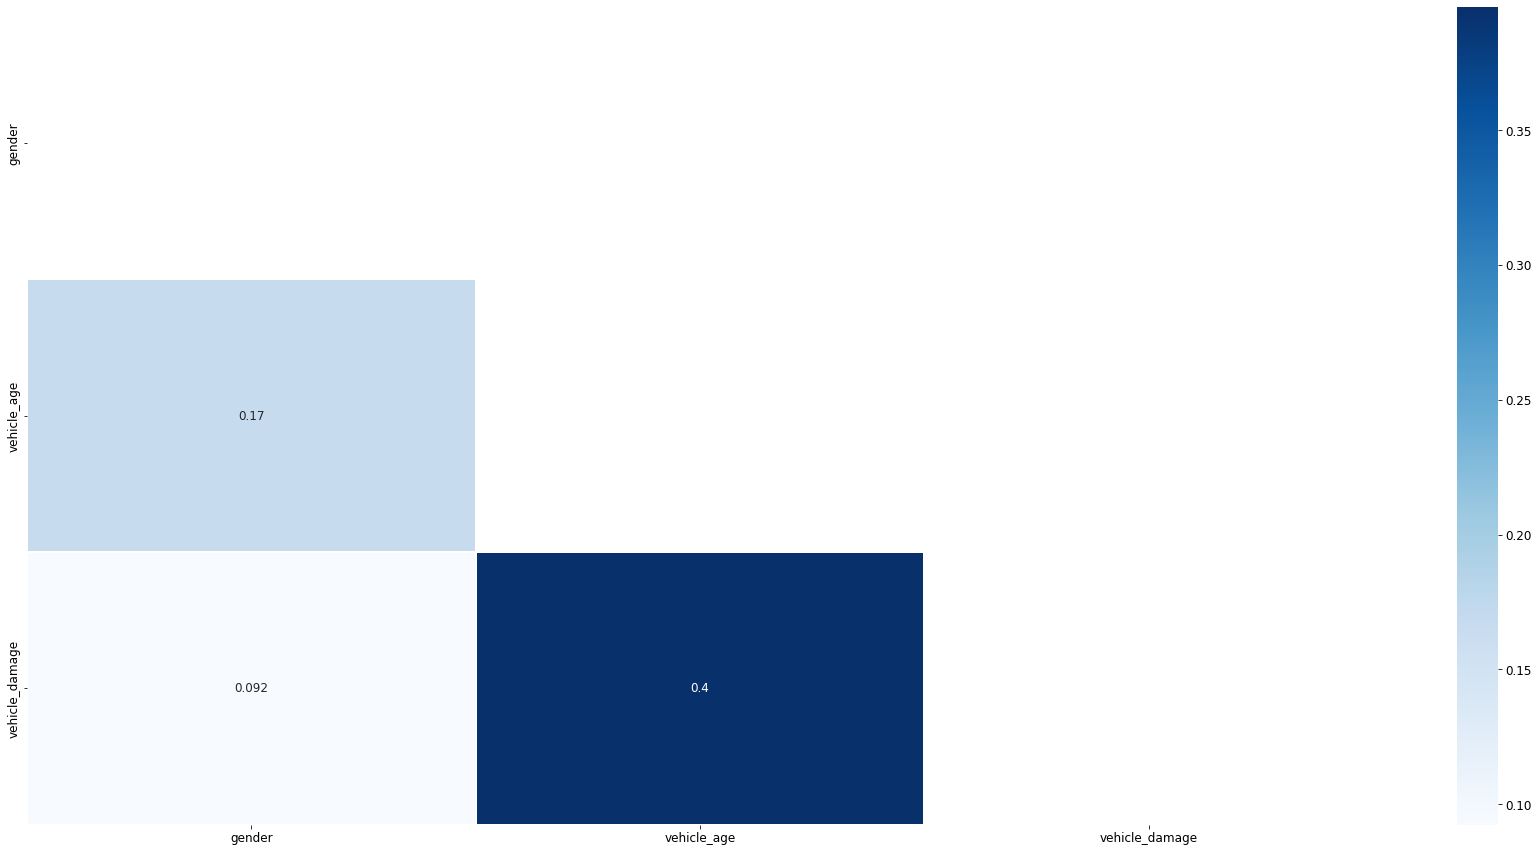

In [34]:
df_cat_var = df.select_dtypes(include=['object', 'category']).astype('category')

dict_cat_var_corr = {}
for x in df_cat_var.columns:

    dict_cat_var_corr[x] = []
    for y in df_cat_var.columns:
        # calculate cramer's v
        dict_cat_var_corr[x].append(mtb.cramers_v(df_cat_var[x], df_cat_var[y]))
    
    # store results
    df_cat_corr = pd.DataFrame(dict_cat_var_corr).set_index(df_cat_var.columns)

# plot settings
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))

# plot
sns.heatmap(df_cat_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

# 4. Data balancing

## 4.1. Encoding

### 4.1.1. Frequency encoding

In [35]:
# encode
col_frequency = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:, 'policy_sales_channel'] = df.loc[:, 'policy_sales_channel'].map(col_frequency)

col_frequency = df.groupby('region_code').size() / len(df)
df.loc[:, 'region_code'] = df.loc[:, 'region_code'].map(col_frequency)

### 4.1.2. One-hot encoding

In [36]:
# define columns to encode
cols_to_ohe_encode = ['gender', 'vehicle_age', 'vehicle_damage']

# encode
df = pd.get_dummies(df, columns=cols_to_ohe_encode, drop_first=True)

## 4.2. Sampling

In [37]:
# over sampling
X_over, y_over = RandomOverSampler(sampling_strategy=0.5).fit_resample(df.drop(['id', 'response'], axis=1), df['response'])

# under sampling
X_combined, y_combined = RandomUnderSampler(sampling_strategy=0.8).fit_resample(X_over, y_over)

In [38]:
# check data size
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329746 entries, 0 to 329745
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   age                                329746 non-null  int64  
 1   region_code                        329746 non-null  float64
 2   policy_sales_channel               329746 non-null  float64
 3   previously_insured                 329746 non-null  int64  
 4   annual_premium                     329746 non-null  float64
 5   vintage                            329746 non-null  int64  
 6   driving_license                    329746 non-null  int64  
 7   older_than_36                      329746 non-null  int64  
 8   vintage_weeks                      329746 non-null  float64
 9   vintage_months                     329746 non-null  float64
 10  annual_premium_per_age             329746 non-null  float64
 11  annual_premium_per_vintage         3297

In [39]:
# check imbalance
print(y_combined.value_counts(normalize=True))

0   0.5556
1   0.4444
Name: response, dtype: float64


# 5. Data preprocessing

## 5.1. Data split

In [40]:
# split data into training and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X_combined, y_combined, test_size=0.2)

In [41]:
# check them out
print(f'Train X: {X_train.shape} | Train Y: {y_train.shape}')
print(f'Val X: {X_val.shape} | Val Y: {y_val.shape}')

Train X: (263796, 19) | Train Y: (263796,)
Val X: (65950, 19) | Val Y: (65950,)


## 5.2. Standardization

In [42]:
# instantiate the scaler
ss = pp.StandardScaler()

# define columns to be rescaled
cols_to_standardize = ['annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_standardize:
    X_train.loc[:, [col]] = ss.fit_transform(X_train.loc[:, [col]])
    joblib.dump(ss, f'../parameters/ss_{col}.pkl')
    X_val.loc[:, [col]] = ss.transform(X_val.loc[:, [col]])

## 5.3. Rescaling

### 5.3.1 MinMax scaler

In [43]:
# instantiate the scaler
mm = pp.MinMaxScaler()

# define columns to be rescaled
cols_to_mm_rescale = ['age', 'vintage', 'vintage_weeks', 'vintage_months', 'customer_characteristic',
                      'annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_mm_rescale:
    X_train.loc[:, [col]] = mm.fit_transform(X_train.loc[:, [col]])
    joblib.dump(mm, f'../parameters/mm_{col}.pkl')
    X_val.loc[:, [col]] = mm.transform(X_val.loc[:, [col]])

### 5.3.2. Robust scaler

In [44]:
# instantiate the scaler
rs = pp.RobustScaler()

# define columns to be rescaled
cols_to_rs_rescale = ['annual_premium_per_vintage', 'annual_premium_per_vintage_weeks', 'annual_premium_per_vintage_months']

# rescale
for col in cols_to_rs_rescale:
    X_train.loc[:, [col]] = rs.fit_transform(X_train.loc[:, [col]])
    joblib.dump(rs, f'../parameters/rs_{col}.pkl')
    X_val.loc[:, [col]] = rs.transform(X_val.loc[:, [col]])

# 6. Feature selection

## 6.1. Boruta as selector

In [45]:
# instantiate the classifier
boruta_xtree = ExtraTreesClassifier()

# instantiate the selector
boruta_selector = BorutaPy(estimator=boruta_xtree, n_estimators=100, verbose=1).fit(X_train.values, y_train.values)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	12


In [47]:
# selected columns by boruta
selected_features_boruta = [col for col, sbcol in zip(X_train.columns, boruta_selector.support_.tolist()) if sbcol]
selected_features_boruta

['age',
 'region_code',
 'policy_sales_channel',
 'previously_insured',
 'annual_premium_per_age',
 'vehicle_age_< 1 Year',
 'vehicle_damage_Yes']

## 6.2. Extra trees as selector

In [48]:
# instantiate and fit the classifier
xtrees_selector = ExtraTreesClassifier(n_estimators=200).fit(X_train, y_train)

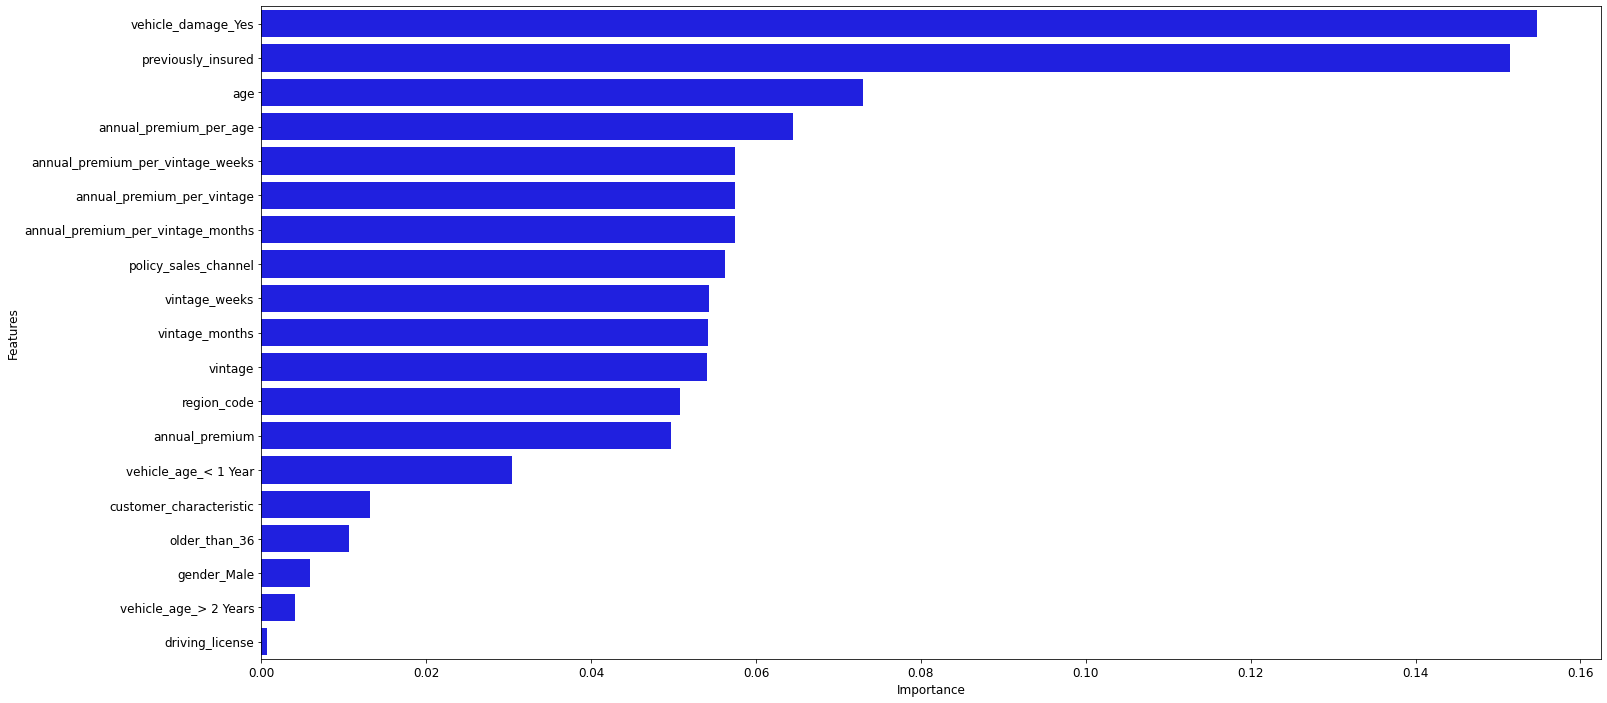

In [49]:
# store features importance
df_xtrees_selector = pd.DataFrame({'Features': X_train.columns,
                                   'Importance': xtrees_selector.feature_importances_})\
                                   .sort_values(by='Importance', ascending=False)\
                                   .reset_index(drop=True)

# plot
sns.barplot(x='Importance', y='Features', data=df_xtrees_selector, orient='h', color='blue');

## 6.3. Columns selection

In [45]:
selected_columns = ['age', 'region_code', 'policy_sales_channel', 'previously_insured',
                    'vehicle_damage_Yes', 'annual_premium', 'annual_premium_per_age']

# select columns
X_train = X_train.loc[:, selected_columns]
X_val = X_val.loc[:, selected_columns]

# check it out
X_train.sample(5)

,age,region_code,policy_sales_channel,previously_insured,vehicle_damage_Yes,annual_premium,annual_premium_per_age
178673,0.4154,0.2691,0.2063,0,1,0.5863,0.2519
37893,0.0769,0.0076,0.3562,0,0,0.4154,0.3490
147156,0.3385,0.0485,0.3562,1,0,0.3394,0.1683
255711,0.2308,0.0109,0.1938,0,1,0.4785,0.2816
325565,0.4615,0.2691,0.0002,0,1,0.4345,0.1769


# 7. Machine learning modeling

In [46]:
# define K value
K = np.floor((1/2) * (y_val.shape[0]))

## 7.1. KNN

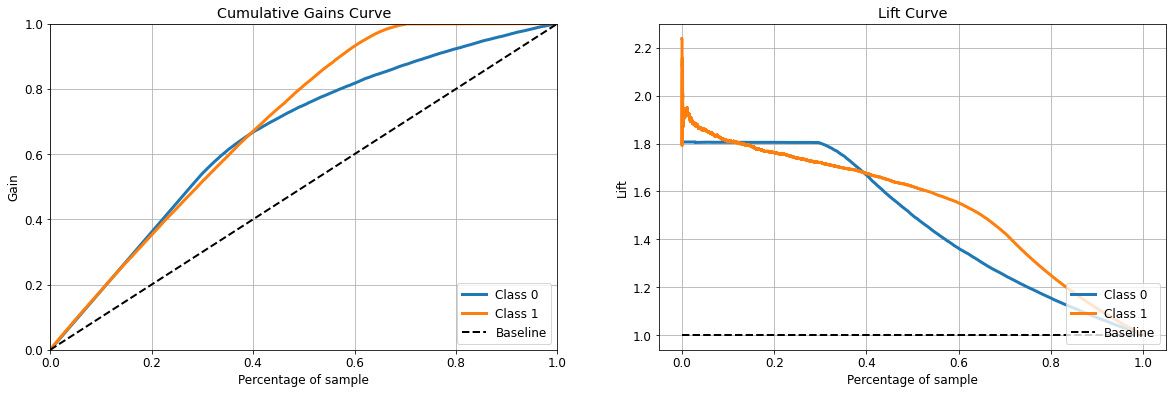

In [48]:
p_hat_knn = train_model(KNeighborsClassifier(n_neighbors=20), X_train, y_train, X_val, y_val)

In [49]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_knn, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_knn, K)}')

Precision@K: 0.7241
Recall@K: 0.8109


### 7.1.1. KNN cross-validation

In [50]:
cross_validation(estimator=KNeighborsClassifier(n_neighbors=20), x=X_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.7231 +/- 0.0021
Recall@K: 0.8145 +/- 0.0023


## 7.2. Logistic regression

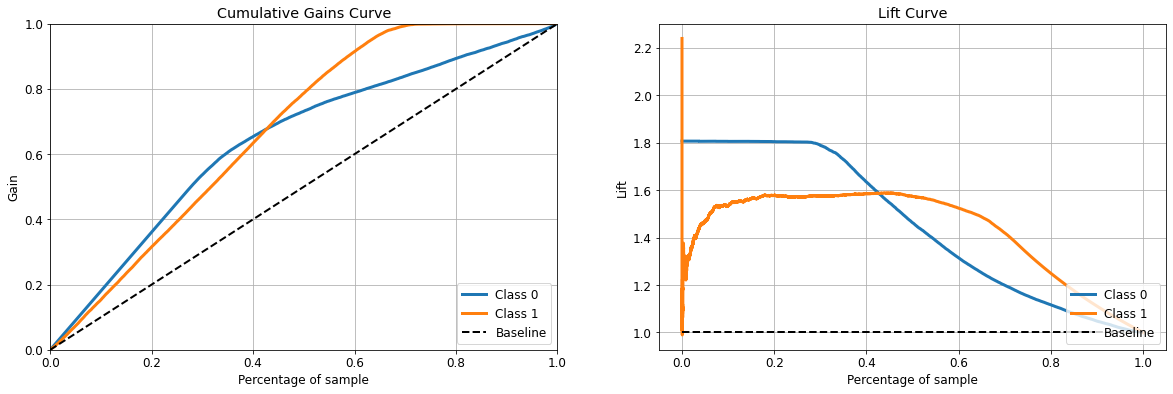

In [51]:
p_hat_lr = train_model(LogisticRegression(), X_train, y_train, X_val, y_val)

In [52]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_lr, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_lr, K)}')

Precision@K: 0.7027
Recall@K: 0.7868


### 7.2.1. Logistic regression cross-validation

In [53]:
cross_validation(estimator=LogisticRegression(), x=X_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.7019 +/- 0.003
Recall@K: 0.7906 +/- 0.0034


## 7.3. Random forest

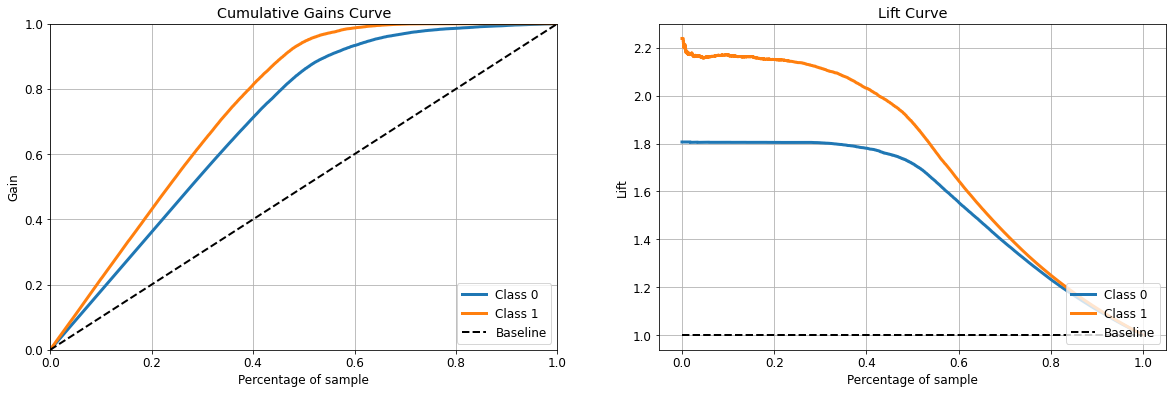

In [54]:
p_hat_rf = train_model(RandomForestClassifier(), X_train, y_train, X_val, y_val)

In [55]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_rf, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_rf, K)}')

Precision@K: 0.8433
Recall@K: 0.9444


### 7.3.1. Random forest cross-validation

In [56]:
cross_validation(estimator=RandomForestClassifier(), x=X_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.8315 +/- 0.002
Recall@K: 0.9366 +/- 0.0022


## 7.4. LightGBM

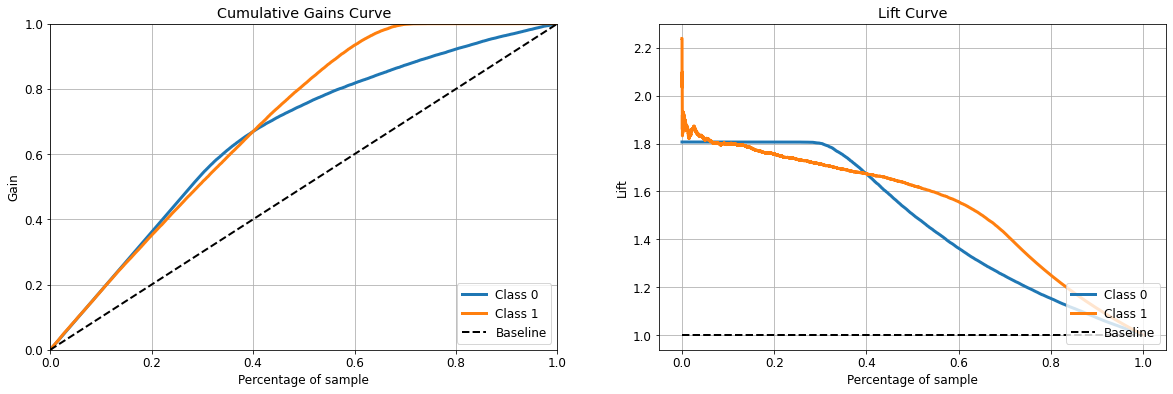

In [57]:
p_hat_lgbm = train_model(LGBMClassifier(), X_train, y_train, X_val, y_val)

In [58]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_lgbm, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_lgbm, K)}')

Precision@K: 0.7257
Recall@K: 0.8127


### 7.4.1. LightGBM cross-validation

In [59]:
cross_validation(estimator=LGBMClassifier(), x=X_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False) 

Precision@K: 0.7264 +/- 0.0026
Recall@K: 0.8182 +/- 0.003


## 7.5. Catboost

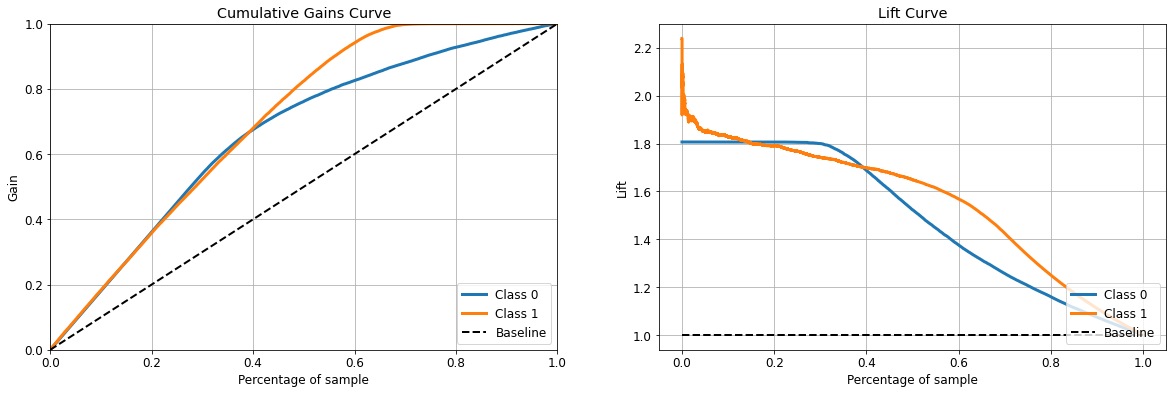

In [60]:
p_hat_cb = train_model(CatBoostClassifier(verbose=False), X_train, y_train, X_val, y_val)

In [61]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_cb, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_cb, K)}')

Precision@K: 0.736
Recall@K: 0.8242


### 7.5.1. Catboost cross-validation

In [62]:
cross_validation(estimator=CatBoostClassifier(verbose=False), x=X_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.7343 +/- 0.0029
Recall@K: 0.8271 +/- 0.0032


# 8. Hyperparameters fine tuning

## 8.1. Random search

In [87]:
# set of parameters to try
search_space = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# instantiate and fit the searcher
search = ms.RandomizedSearchCV(RandomForestClassifier(), param_distributions=search_space, n_iter=5, cv=5).fit(X_train, y_train)

In [88]:
# best model
search.best_estimator_

RandomForestClassifier(min_samples_split=3, n_estimators=300)

## 8.2. Evaluate tuned model

In [50]:
# instantiate, fit and serialize the tuned model
model = RandomForestClassifier(min_samples_split=3, n_estimators=100).fit(X_train, y_train)
joblib.dump(model, '../models/model.pkl')

['../models/model.pkl']

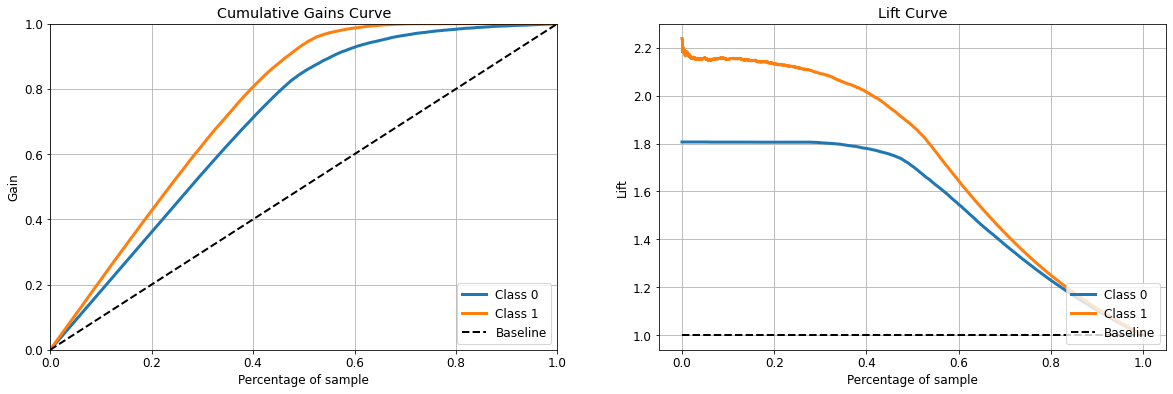

In [51]:
# predict
p_hat = model.predict_proba(X_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# cumulative gain
plot_cumulative_gain(y_val, p_hat, ax=ax1);

# lift curve
plot_lift_curve(y_val, p_hat, ax=ax2);

In [53]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat, K)}')

Precision@K: 0.8367
Recall@K: 0.9369


# 9. Calibration

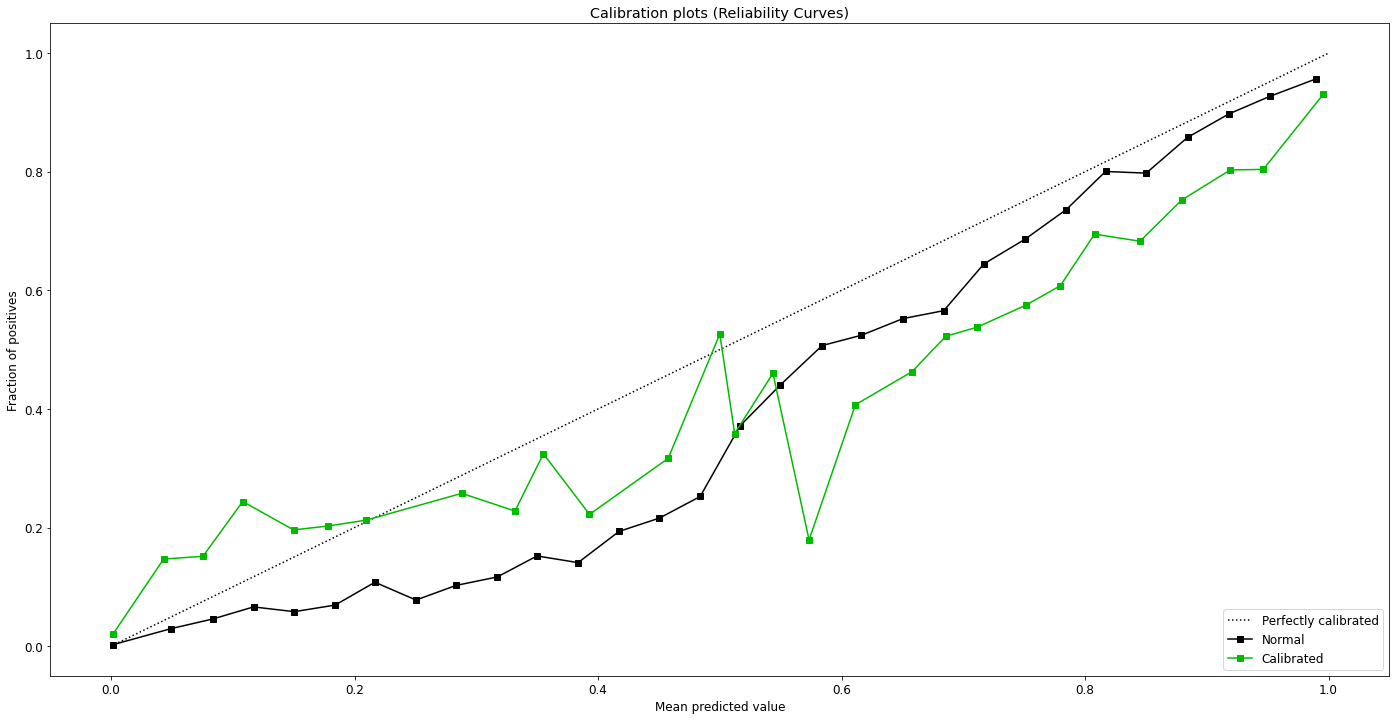

In [56]:
# calibrate
model_calibrated = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit').fit(X_train, y_train)

# predict
p_hat_calibrated = model_calibrated.predict_proba(X_val)

# plot calibration curve
plot_calibration_curve(y_true=y_val,
                       clf_names=['Normal', 'Calibrated'],
                       probas_list=[p_hat, p_hat_calibrated],
                       n_bins=30);

## 9.1. Evaluate calibrated model

In [57]:
# calculate brier score loss for each model
bsl_model = brier_score_loss(y_val, p_hat[:, 1])
bsl_model_calibrated = brier_score_loss(y_val, p_hat_calibrated[:, 1])

# compare them
print(f'Brier score loss before the calibration: {bsl_model}')
print(f'Brier score loss after the calibration: {bsl_model_calibrated}\n')

# check it out
if bsl_model_calibrated > bsl_model:
    print('Calibrated model is NOT better.')
else:
    print('Calibrated model is better.')

Brier score loss before the calibration: 0.08543217721308627
Brier score loss after the calibration: 0.08708695366173272

Calibrated model is NOT better.


# 10. Deploy

## 10.1. Pipeline class

In [74]:
import os
import joblib
import pandas as pd

class PipelineVehicleInsurance:
    def __init__(self):
        # define home path directory
        self.HOME_PATH = os.getcwd().replace(r'\src\api', '')
        
        # load parameters
        self.ss_annual_premium_per_age = joblib.load(self.HOME_PATH + r'\parameters\ss_annual_premium_per_age.pkl')
        self.ss_annual_premium = joblib.load(self.HOME_PATH + r'\parameters\ss_annual_premium.pkl')
        self.mm_age = joblib.load(self.HOME_PATH + r'\parameters\mm_age.pkl')
        self.mm_annual_premium_per_age = joblib.load(self.HOME_PATH + r'\parameters\mm_annual_premium_per_age.pkl')
        self.mm_annual_premium = joblib.load(self.HOME_PATH + r'\parameters\mm_annual_premium.pkl')
    
    
    def data_cleansing(self, df):
        # convert to integer
        df['region_code'] = df.loc[:, 'region_code'].astype('int64')
        df['policy_sales_channel'] = df.loc[:, 'policy_sales_channel'].astype('int64')

        # convert to category
        df['vehicle_damage'] = df.loc[:, 'vehicle_damage'].astype('category')
        
        return df
    
    
    def feature_engineering(self, df):
        # annual_premium
        df['annual_premium_per_age'] = df['annual_premium'] / df['age']
        
        return df
    
    
    def data_preprocessing(self, df):
        # frequency encoding
        col_frequency = df.groupby('policy_sales_channel').size() / len(df)
        df.loc[:, 'policy_sales_channel'] = df.loc[:, 'policy_sales_channel'].map(col_frequency)

        col_frequency = df.groupby('region_code').size() / len(df)
        df.loc[:, 'region_code'] = df.loc[:, 'region_code'].map(col_frequency)

        # one-hot encoding
        df = pd.get_dummies(df, columns=['vehicle_damage'], drop_first=True)
        
        # standardization
        df.loc[:, ['annual_premium_per_age']] = self.ss_annual_premium_per_age.transform(df.loc[:, ['annual_premium_per_age']])
        df.loc[:, ['annual_premium']] = self.ss_annual_premium.transform(df.loc[:, ['annual_premium']])
        
        # minmax rescaling
        df.loc[:, ['annual_premium_per_age']] = self.mm_annual_premium_per_age.transform(df.loc[:, ['annual_premium_per_age']])
        df.loc[:, ['annual_premium']] = self.mm_annual_premium.transform(df.loc[:, ['annual_premium']])
        
        return df.loc[:, ['age', 'region_code', 'policy_sales_channel', 'previously_insured',
                          'vehicle_damage_Yes', 'annual_premium', 'annual_premium_per_age']]
    
    
    def get_ranking(self, estimator, original_data, test_data):
        # calculate probability
        p_hat = estimator.predict_proba(test_data)
        
        # rank
        original_data['score'] = p_hat[:, 1].tolist()
        original_data.sort_values(by='score', ascending=False, inplace=True)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API handler

In [89]:
import os
import joblib
from flask import Flask, request, Response
import pandas as pd
from vehicleinsurance import PipelineVehicleInsurance

# load model
HOME_PATH = os.getcwd().replace(r'\src\api', '')
model = joblib.load(HOME_PATH + r'\models\model.pkl')

# initialize API
app = Flask(__name__)

# create endpoint
@app.route('/rank', methods=['POST'])
def vehicle_insurance_ranking():
    test_json = request.get_json()

    # check if there is data
    if test_json:
        # check how much data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate pipeline class
        pipeline = PipelineVehicleInsurance()

        # data cleansing
        df = pipeline.data_cleansing(test_raw)

        # feature engineering
        df = pipeline.feature_engineering(df)

        # data preprocessing
        df = pipeline.data_preprocessing(df)

        # get ranking
        df_response = pipeline.get_ranking(model, test_raw, df)

        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    PORT = os.environ.get('PORT', 5000)
    app.run('192.168.0.18', port=PORT, debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000 (Press CTRL+C to quit)


## 10.3. API test

In [82]:
# convert test data set into json
data = json.dumps(X_test.to_dict(orient='records'))

# call API
# url = 'http://192.168.0.18:5000/rank'
url = 'https://vehicle-insurance-cross-sell.herokuapp.com/rank'
header = {'Content-type': 'application/json'}
r = requests.post(url, data=data, headers=header)

# check it out
print(f'Status code: {r.status_code}')

Status code: 200


In [83]:
# check it out
df_results = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_results.head(5)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,annual_premium_per_age,score
0,354526,Male,78,0.0007,0.2058,0,42960.0000,159,1,1-2 Year,Yes,550.7692,0.7867
1,81352,Female,76,0.0350,0.0017,0,32039.0000,140,1,1-2 Year,Yes,421.5658,0.7467
2,116974,Male,79,0.2790,0.0004,0,38325.0000,64,1,> 2 Years,Yes,485.1266,0.7417
3,300890,Female,76,0.0519,0.1954,0,33086.0000,162,1,1-2 Year,Yes,435.3421,0.7183
4,82394,Female,80,0.2790,0.0264,0,31396.0000,55,1,1-2 Year,Yes,392.4500,0.7067


In [106]:
# concatenate test dataset
df_test = pd.concat([X_test, y_test], axis=1)

# merge
df_final = pd.merge(df_test[['id', 'response']], df_results[['id', 'score']], how='left', on='id').set_index('id')

# check if they are the same
len(X_test) == len(df_final)

True

In [107]:
# check results
df_final.sort_values('score', ascending=False).head(10)

,response,score
id,,
354526,0,0.7867
81352,1,0.7467
116974,1,0.7417
300890,0,0.7183
82394,0,0.7067
320458,0,0.7050
312977,0,0.6950
209979,0,0.6917
369115,1,0.6808
